In [39]:
import pandas as pd
import random
import numpy as np
from statsmodels.formula.api import logit
from plotnine import *
import sklearn.ensemble
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import matplotlib.pylab as plt
from clean_data import *

In [40]:
#Reading the data in
df = pd.read_csv("data/loan_level_500k.csv", low_memory=False, index_col=19)

In [41]:
#Tidying data with script
df = tidy_data(df)

In [42]:
#Sampling our data for our Logistic Regression due to computational constraints
df = df.sample(10000)

Now we are onto the machine learning component.

We decided to run a logistic regression instead of something like a linear regression because we were trying to predict the categorical variable of delinquency. Categorical variables are better predicted using a logistic regression over a linear regression. 

The following is the code used to run the logistic regression followed by some analysis of our model.

In [43]:
#Function from Project 4 with slight modification to return the actual model aswell
def get_roc_data(model, cv_obj):
    curve_df = None
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (train, test) in enumerate(cv_obj.split(X, y)):
        model.fit(X[train], y[train])
        scores = model.predict_proba(X[test])[:,1]
        fpr, tpr, _ = sklearn.metrics.roc_curve(y[test],scores)
        
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tmp = pd.DataFrame({'fold':i, 'fpr': mean_fpr, 'tpr': interp_tpr})
        curve_df = tmp if curve_df is None else pd.concat([curve_df, tmp])
        
        aucs.append(sklearn.metrics.auc(fpr, tpr))
        
    curve_df = curve_df.groupby('fpr').agg({'tpr': 'mean'}).reset_index()
    curve_df.iloc[-1,1] = 1.0
    
    auc_df = pd.DataFrame({'fold': np.arange(len(aucs)), 'auc': aucs})
    return curve_df, auc_df, model

In [44]:
#Logistic Regression Prep
cv_obj = sklearn.model_selection.StratifiedKFold(n_splits=10)

lr = sklearn.linear_model.LogisticRegression(n_jobs = -1)
parameters = {}

lr_cv = sklearn.model_selection.GridSearchCV(lr, parameters, cv=10)

In [45]:
#Using Function from clean_data script to split into testing and training data
train,test, _ = get_train_test_split_for_ml(df, 2000,pre_process=True )

In [46]:
#Removing attributes
X = train.drop(["DELINQUENT","PREPAID"],axis=1).to_numpy()
y = train["DELINQUENT"]

In [47]:
#Using Function From Project 4 to train the logistic regression model
lr_curve_df, lr_auc_df, trained_model = get_roc_data(lr_cv, cv_obj)

lr_curve_df['model'] = 'logistic regression'
lr_auc_df['model'] = 'logistic regression'

A confusion matrix was produced after running our testing data against our logistic regression model to see what kind of results we would get. A confusion matrix is a 2x2 table that shows us the following values: True Positive, False Positive, True Negative and False Negative. These values are indicative of whether the model correctly or incorrectly predicted a delinquent or non-delinquent person. 

True Positive: Correctly predicted a Delinquent
False Positive: Incorrectly Predicted a Delinquent
True Negative: Correctly predicted a non-Delinquent
False Negative: Incorrectly Predicted a non-Delinquent

In [48]:
#Generating the Confusion Matrix using our test data
from sklearn.metrics import confusion_matrix

X = test.drop(["DELINQUENT","PREPAID"],axis=1).to_numpy()
y = test["DELINQUENT"]

scores = trained_model.predict_proba(X)[:,1]
scores = [1 if i > 0.5 else 0 for i in scores]

cm = confusion_matrix(y, scores)
print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[4572   15]
 [ 197    0]]


From these values we can evaluate the strength of our logistic regression model by calculating the Error Rate, Accuracy, Sensitivity and Specificity

In [49]:
#Printing out each value from the Confusion Matrix
tn, fp, fn, tp = cm.ravel()
(tn, fp, fn, tp)

(4572, 15, 197, 0)

In [50]:
#Evaluation of Confusion Matrix
total = (tn + fp + fn + tp)

#Error Rate:
er = (fp + fn) / total

#Accuracy:
acc = (tp + tn) / total

#Sensitivity
sens = tp / (tp + fp)

#Specificity
spec = tn / (tn + fn)

(er, acc, sens, spec)

(0.04431438127090301, 0.955685618729097, 0.0, 0.9586915495911092)

Error Rate: This model has a low error rate which is good. This means that it has a very small chance of predicting an incorrect outcome.
Accuracy: When a model has a low error rate, it typically has a high accuracy rate which means that it correctly predicts the outcome of our testing data most of the time. Our model is very accurate.
Specificity: This model is highly specific. This means that our model high a high amount of correct negative predictions.
Sensitivity: This model has a very poor sensitivity. This means that it has a very low amount of correct positive predictions. We think that we did not get any true positives from our model because of the overwhelming amounts on non-delinquent data we used to build the model. A way we could possibly improve this is by changing our sample to include more delinquent data.

Lets move onto a visual respresentation of our model. The following is our ROC data and our AUROC curve

In [51]:
#ROC data
lr_curve_df

,fpr,tpr,model
0,0.000000,0.000000,logistic regression
1,0.010101,0.066993,logistic regression
2,0.020202,0.106536,logistic regression
3,0.030303,0.151307,logistic regression
4,0.040404,0.179739,logistic regression
...,...,...,...
95,0.959596,1.000000,logistic regression
96,0.969697,1.000000,logistic regression
97,0.979798,1.000000,logistic regression
98,0.989899,1.000000,logistic regression


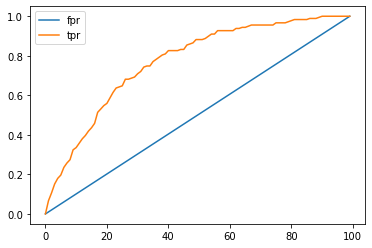

In [52]:
#Plot of ROC Curve
lr_curve_df.plot.line()

In our AUROC Curve, we see two lines. The line at 45 degrees symbolizes using a 50-50 approach of guessing whether someone was delinquent or not. The orange line above this 45-degree line is our logistic regression model. The greater the y-value, the more accurate the model is at predicting whether someone is delinquent. A perfect model would have a consistent y-value of 1. We can deduce from this graph that our logistic regression model is quite a bit better at predicting whether someone is delinquent than just random guessing. 

In our hypothesis testing we said that we picked variables based on how correlated they were based on our correlation matrix. Since all those variables resulted in a p_value of less than 0.05, they were all deemed to be significant variables for our models. If one or more of those variables were over the significance value of 0.05 then we would have run another logistic regression excluding those variables and would compare the AUROC curves of both models. 

In [53]:
#AUC data - Don't really know what to do with this and below
lr_auc_df

,fold,auc,model
0,0,0.748236,logistic regression
1,1,0.764881,logistic regression
2,2,0.850639,logistic regression
3,3,0.777227,logistic regression
4,4,0.804784,logistic regression
5,5,0.733466,logistic regression
6,6,0.756769,logistic regression
7,7,0.800641,logistic regression
8,8,0.710846,logistic regression
9,9,0.742766,logistic regression


In [54]:
#average AUC
lr_auc_df["auc"].mean()

0.769025444284186